In [1]:
import sys
sys.path.append('/home/ubuntu/scripts/')

In [2]:
from starter import *

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
RANDOM_SEED = 2018
random.seed(RANDOM_SEED)

## Load data

In [5]:
consumption_test = pd.read_csv('cold_start_test.csv', index_col=[0], parse_dates=[2])
consumption_train = pd.read_csv('consumption_train.csv', index_col=[0], parse_dates=[2])
meta = pd.read_csv('new_meta.csv', index_col=[0], converters={'days_off':str})
submission_format = pd.read_csv('new_submission_format.csv', index_col=[0], parse_dates=[2])

In [6]:
df = consumption_train.copy()
df['train'] = 1
df = df.append(consumption_test)
df['train'].fillna(0, inplace=True)

Select train and test series

In [7]:
def describe_training_data(train_df):
    num_training_series = train_df.series_id.nunique()
    num_training_days = num_training_series * 28
    num_training_hours = num_training_days * 24
    assert num_training_hours == train_df.shape[0]
    
    desc = f'There are {num_training_series} training ' \
           f'series totaling {num_training_days} days ' \
           f'({num_training_hours} hours) of consumption data.'
    
    print(desc)

In [8]:
meta.days_off.value_counts()

0000011    1236
0000000     104
0000001      21
0000111      10
0000010       5
1111111       4
0011111       3
Name: days_off, dtype: int64

In [9]:
describe_training_data(consumption_train)

There are 758 training series totaling 21224 days (509376 hours) of consumption data.


In [8]:
# choose subset of series to use
frac_series_to_use = 0.2
rng = np.random.RandomState(seed=RANDOM_SEED)
series_ids = consumption_train.series_id.unique()
series_mask = rng.binomial(1,
                           frac_series_to_use,
                           size=series_ids.shape).astype(bool)
series_data = series_ids[series_mask]

# allocate 1/3 of data to testing set
test_series = series_data[rng.binomial(1, 0.2, size=series_data.shape).astype(bool)]
train_series = [x for x in series_data if x not in test_series]

# reduce training data to series subset
consumption_test = consumption_train[consumption_train.series_id.isin(test_series)]
consumption_train = consumption_train[consumption_train.series_id.isin(train_series)]

# # describe the reduced set
describe_training_data(consumption_train)

There are 122 training series totaling 3416 days (81984 hours) of consumption data.


In [9]:
len(train_series), len(test_series)

(122, 39)

## Create prediction windows for test set

Create training set first

In [10]:
pred_groups = pd.DataFrame(data={'series_id':test_series, 'prediction_window':[random.choice(['hourly','daily','weekly']) for _ in range(39)]})
test_window = pred_groups.merge(
    consumption_test[consumption_test.series_id==pred_groups.series_id.values.tolist()[0]]
                                .iloc[:50,:], on='series_id', how='inner')
for i in pred_groups.series_id.values.tolist()[1:]:
    test_window = pd.concat([test_window, pred_groups.merge(
        consumption_test[consumption_test.series_id==i].iloc[:50,:], on='series_id', how='inner')])

In [11]:
def create_scoring_format():
    pred_scoring = test_window[test_window.series_id==pred_groups.series_id.values.tolist()[0]][40:50]
    for j in pred_groups.series_id.values.tolist()[1:]:
        pred_scoring = pd.concat([pred_scoring, test_window[test_window.series_id==j][40:50]])
    pred_scoring.set_index('timestamp', inplace=True)
    return pred_scoring

In [12]:
pred_scoring = create_scoring_format()

In [14]:
# map_window = {'daily':7,'hourly':14,'weekly':2}
# test_window['total_row'] = test_window.apply(
#     lambda row: map_window[row['prediction_window']], axis=1)

In [13]:
print('Unique series_id: ', test_window.series_id.nunique())
# all([x==14 for x in test_window[test_window.prediction_window=='hourly'].groupby('series_id').size()])
# all([x==7 for x in test_window[test_window.prediction_window=='daily'].groupby('series_id').size()])
# all([x==2 for x in test_window[test_window.prediction_window=='weekly'].groupby('series_id').size()])

Unique series_id:  39


## Explore data

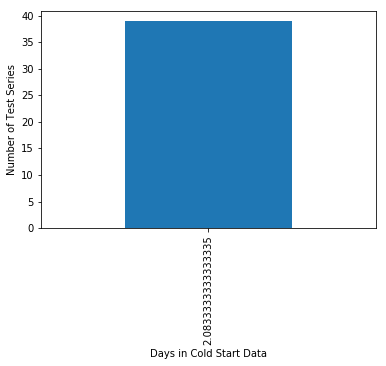

In [16]:
ax = (test_window.groupby('series_id').count()
                                           .timestamp
                                           .divide(24)
                                           .value_counts()
                                           .sort_index()
                                           .plot.bar())
ax.set_xlabel('Days in Cold Start Data')
ax.set_ylabel('Number of Test Series')
plt.show()

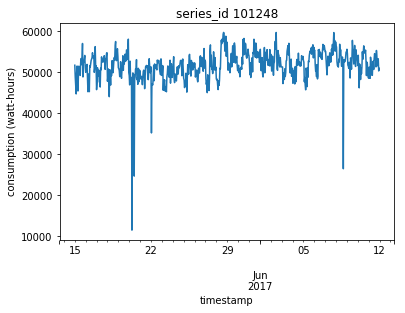

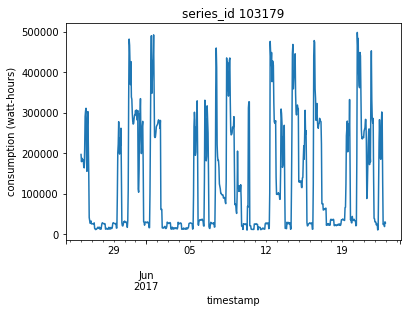

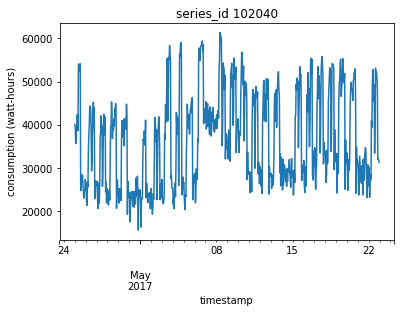

In [14]:
# plot a few consumption patterns
series_to_plot = rng.choice(consumption_train.series_id.unique(), 3)

for ser_id in series_to_plot:
    ser_data = consumption_train[consumption_train.series_id == ser_id]
    ax = ser_data.plot(x='timestamp',
                       y='consumption', 
                       title=f"series_id {int(ser_id)}",
                       legend=False)
    plt.ylabel('consumption (watt-hours)')
    plt.show()

In [15]:
(consumption_train.groupby('series_id')
                  .timestamp
                  .apply(lambda x: x.max() - x.min())
                  .value_counts())

27 days 23:00:00    122
Name: timestamp, dtype: int64

## Set up data for model

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model
from subprocess import check_output

from tqdm import tqdm

Using TensorFlow backend.


In [14]:
def create_lagged_features(df, lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=['consumption'])
    
    def _rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        df = df.join(df.consumption.shift(i).pipe(_rename_lag, i))

    df.dropna(inplace=True)
    return df

In [15]:
def prepare_training_data(consumption_series, lag):
    """ Converts a series of consumption data into a
        lagged, scaled sample.
    """
    # scale training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    consumption_vals = scaler.fit_transform(consumption_series.values.reshape(-1, 1))
    
    # convert consumption series to lagged features
    consumption_lagged = create_lagged_features(consumption_vals, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = consumption_lagged.drop('consumption', axis=1).values
    y = consumption_lagged.consumption.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scaler

In [16]:
# try example set
example_series = consumption_train[consumption_train.series_id == train_series[0]].reset_index(drop=True)
example_series.index = example_series.timestamp
create_lagged_features(example_series[['consumption']], lag=3).head()

,consumption,consumption_1,consumption_2,consumption_3
timestamp,,,,
2015-06-10 03:00:00,394713.066332,381710.334453,449381.725991,385788.336160
2015-06-10 04:00:00,396222.395699,394713.066332,381710.334453,449381.725991
2015-06-10 05:00:00,403215.934258,396222.395699,394713.066332,381710.334453
2015-06-10 06:00:00,399278.553300,403215.934258,396222.395699,394713.066332
2015-06-10 07:00:00,402405.021275,399278.553300,403215.934258,396222.395699


In [73]:
_X, _y, scaler = prepare_training_data(example_series.consumption, 5)
print(_X.shape)
print(_y.shape)
print(scaler)

(667, 1, 5)
(667,)
MinMaxScaler(copy=True, feature_range=(-1, 1))


## Fit model

In [17]:
def set_model(lag=24, num_neurons=24, batch_size=1):
    # model parameters
    batch_input_shape=(batch_size, 1, lag)
    
    #set up model
    model = Sequential()
    model.add(LSTM(units=num_neurons, batch_input_shape=batch_input_shape, stateful=True, return_sequences=True, dropout=0.2))
    model.add(LSTM(units=100, stateful=True, activation='relu', dropout=0.2))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    
    return model

In [22]:
for i in consumption_train.series_id.unique()[:10]:
    shape_train = consumption_train[consumption_train.series_id==i].shape[0]
    print(shape_train, int(shape_train)/24)

672 28.0
672 28.0
672 28.0
672 28.0
672 28.0
672 28.0
672 28.0
672 28.0
672 28.0
672 28.0


It looks like we can use batch sizes of up to 24 and 28.

In [18]:
def fit_model(model, train_data, n_epochs=3, batch_size=1):
    """ Fits model on training data on each series_id with specified
        number of epochs.
    """
    for i in tqdm(range(n_epochs), total=n_epochs, desc='Learning Consumption Trends - Epochs'):
        
        # reset the LSTM state for training on each series
        for ser_id, ser_data in train_data.groupby('series_id'):
            # prepare the data
            X, y, scaler = prepare_training_data(ser_data.consumption, lag)
            #fit the model
            model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
#             model.fit(X, y, epochs=1, batch_input_shape=(n_batch, train_X.shape[1], train_X.shape[2]),
#                       verbose=1, shuffle=False)
            model.reset_states()
    return model

In [19]:
def generate_hourly_forecast(num_pred_hours, consumption, model, scaler, lag, batch_size):
    """ Uses last hour's prediction to generate next for num_pred_hours, 
        initialized by most recent cold start prediction. Inverts scale of 
        predictions before return.
    """
   # allocate prediction frame
    preds_scaled = np.zeros(num_pred_hours)
    
    # initial X is last lag values from the cold start
    X = scaler.transform(consumption.values.reshape(-1, 1))[-lag:]
    
    # forecast
    for i in range(num_pred_hours):
        # predict scaled value for next time step
        yhat = model.predict(X.reshape(1, 1, lag), batch_size=1)[0][0]
        preds_scaled[i] = yhat
        
        # update X to be latest data plus prediction
        X = pd.Series(X.ravel()).shift(-1).fillna(yhat).values

    # revert scale back to original range
    hourly_preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).ravel()
    return hourly_preds

In [20]:
# num_pred_hours = 10
# num_test_series = consumption_test.series_id.nunique()
# for ser_id, pred_df in tqdm(consumption_test.groupby('series_id'),
#                            total=num_test_series,
#                            desc='Forecasting from Cold Start Data'):
#     series_data = consumption_test[consumption_test.series_id==ser_id].consumption[:20]
#     cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
#     model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
#     y_pred = generate_hourly_forecast(num_pred_hours, series_data, model, scaler, lag, batch_size)
#     y_real = consumption_test[consumption_test.series_id==ser_id].consumption[20:]
#     model.reset_states()
#     print(RMSE(y_real, y_pred))

In [21]:
def generate_complete_forecast(model, test_data, submission, lag=24, batch_size=1):
    # set definitions of prediction windows
    pred_window_to_num_preds = {'hourly': 24, 'daily': 7, 'weekly': 2}
    pred_window_to_num_pred_hours = {'hourly': 24, 'daily': 7 * 24, 'weekly': 2 * 7 * 24}
    
    num_test_series = submission.series_id.nunique()
    model.reset_states()
    
    for ser_id, pred_df in tqdm(submission.groupby('series_id'),
                               total=num_test_series,
                               desc="Forecasting from Cold Start Data"):
        
        # get info about this series' prediction window
        pred_window = pred_df.prediction_window.unique()[0]
        num_preds = pred_window_to_num_preds[pred_window]
        num_pred_hours = pred_window_to_num_pred_hours[pred_window]
        
        # prepare cold start data
        series_data = consumption_test[consumption_test.series_id == ser_id].consumption
        cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
        
        # fine tune our lstm model to this site using cold start data    
        model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)

        # make hourly forecasts for duration of pred window
        preds = generate_hourly_forecast(num_pred_hours, series_data, model, scaler, lag, batch_size)

        # reduce by taking sum over each sub window in pred window
        reduced_preds = [pred.sum() for pred in np.split(preds, num_preds)]

        # store result in submission DataFrame
        ser_id_mask = my_submission.series_id == ser_id
        my_submission.loc[ser_id_mask, 'consumption'] = reduced_preds
        
    return model, my_submission

In [22]:
# set parameters
lag = 12
num_neurons = 24
batch_size = 1
n_epochs = 20

In [23]:
from keras import backend as K

In [24]:
# set up model architecture
model = set_model(lag=lag, num_neurons=num_neurons, batch_size=batch_size)

# fit model on training data
model = fit_model(model, consumption_train, n_epochs=n_epochs, batch_size=batch_size)

Learning Consumption Trends - Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/1
660/660 [==============================] - 6s 10ms/step - loss: 0.3586
Epoch 1/1
660/660 [==============================] - 4s 6ms/step - loss: 0.2439
Epoch 1/1
 81/660 [==>...........................] - ETA: 3s - loss: 0.3001

KeyboardInterrupt: 

In [28]:
model.save('my_model.h5')

In [99]:
num_pred_hours = 10
num_test_series = consumption_test.series_id.nunique()
for ser_id, pred_df in tqdm(consumption_test.groupby('series_id'),
                           total=num_test_series,
                           desc='Forecasting from Cold Start Data'):
    series_data = consumption_test[consumption_test.series_id==ser_id].consumption[:40]
    cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
    model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    y_pred = generate_hourly_forecast(num_pred_hours, series_data, model, scaler, lag, batch_size)
    y_real = consumption_test[consumption_test.series_id==ser_id].consumption[40:50]
    model.reset_states()
    pred_scoring.loc[pred_scoring.series_id==ser_id,'prediction'] = y_pred
    print(RMSE(y_real, y_pred))

Forecasting from Cold Start Data:   5%|▌         | 2/39 [00:00<00:22,  1.64it/s]

47515.21917172555
58667.23548603645


Forecasting from Cold Start Data:  10%|█         | 4/39 [00:01<00:13,  2.60it/s]

122874.437347003
24049.30070230508


Forecasting from Cold Start Data:  15%|█▌        | 6/39 [00:01<00:09,  3.58it/s]

10857.775013443985
111775.09105607192


Forecasting from Cold Start Data:  21%|██        | 8/39 [00:02<00:07,  4.43it/s]

16319.408890576751
106074.11080362504


Forecasting from Cold Start Data:  26%|██▌       | 10/39 [00:02<00:05,  5.05it/s]

3714.982930072896
7996.174657586757


Forecasting from Cold Start Data:  31%|███       | 12/39 [00:02<00:04,  5.47it/s]

1033.469552168902
36937.86791515047


Forecasting from Cold Start Data:  36%|███▌      | 14/39 [00:03<00:04,  5.48it/s]

4076.77109777807
187513.42137524323


Forecasting from Cold Start Data:  41%|████      | 16/39 [00:03<00:04,  5.50it/s]

13510.482520776906
6867.665403681511


Forecasting from Cold Start Data:  46%|████▌     | 18/39 [00:03<00:03,  5.53it/s]

11286.144021005475
10398.020345617317


Forecasting from Cold Start Data:  51%|█████▏    | 20/39 [00:04<00:03,  5.61it/s]

33206.398274711566
23166.107231858226


Forecasting from Cold Start Data:  56%|█████▋    | 22/39 [00:04<00:02,  5.71it/s]

531572.8282584309
2574.63633642146


Forecasting from Cold Start Data:  62%|██████▏   | 24/39 [00:04<00:02,  5.67it/s]

2095.544853687094
67685.12271052308


Forecasting from Cold Start Data:  67%|██████▋   | 26/39 [00:05<00:02,  5.70it/s]

78612.85526340033
1613.311424901091


Forecasting from Cold Start Data:  72%|███████▏  | 28/39 [00:05<00:01,  5.71it/s]

90687.2424106014
13632.432789074617


Forecasting from Cold Start Data:  77%|███████▋  | 30/39 [00:05<00:01,  5.76it/s]

4866.965718628345
1481.6273003963602


Forecasting from Cold Start Data:  82%|████████▏ | 32/39 [00:06<00:01,  5.78it/s]

5918.528025341901
34744.69124562324


Forecasting from Cold Start Data:  87%|████████▋ | 34/39 [00:06<00:00,  5.73it/s]

29752.632763891943
4029.725050350469


Forecasting from Cold Start Data:  92%|█████████▏| 36/39 [00:06<00:00,  5.71it/s]

118979.11958268213
79234.42978272363


Forecasting from Cold Start Data:  97%|█████████▋| 38/39 [00:07<00:00,  5.72it/s]

9902.221925917971
14063.370398528381


Forecasting from Cold Start Data: 100%|██████████| 39/39 [00:07<00:00,  5.72it/s]

9440.588417729608


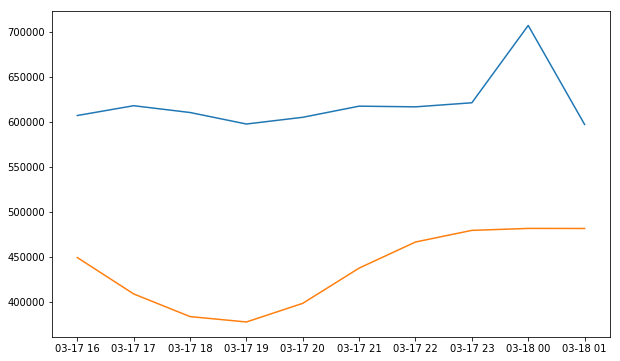

In [105]:
plt.subplots(1,1,figsize=(10,6))
k = 1
plt.plot(pred_scoring.loc[pred_scoring.series_id==test_series[k]].index, pred_scoring.loc[pred_scoring.series_id==test_series[k],'consumption'], label='consumption')
plt.plot(pred_scoring.loc[pred_scoring.series_id==test_series[k]].index, pred_scoring.loc[pred_scoring.series_id==test_series[k],'prediction'], label='prediction')

Add testing functions here

- fit model to first part of test set
- predict and score

In [35]:
test_window

,prediction_window,series_id,timestamp,consumption,temperature
0,daily,103088,2014-12-24 00:00:00,101842.233424,NaN
1,daily,103088,2014-12-24 01:00:00,105878.048906,NaN
2,daily,103088,2014-12-24 02:00:00,91619.105008,NaN
3,daily,103088,2014-12-24 03:00:00,94473.706203,NaN
4,daily,103088,2014-12-24 04:00:00,96976.755526,NaN
5,daily,103088,2014-12-24 05:00:00,109154.512346,NaN
6,daily,103088,2014-12-24 06:00:00,91909.721222,NaN
7,daily,103088,2014-12-24 07:00:00,100895.387051,NaN
8,daily,103088,2014-12-24 08:00:00,99821.982004,NaN
9,daily,103088,2014-12-24 09:00:00,91215.992196,NaN


In [30]:
# copy submission format and fill in values
my_submission = submission_format.copy()
model, my_submission = generate_complete_forecast(model, consumption_test, my_submission, lag=lag, batch_size=batch_size)

Forecasting from Cold Start Data: 100%|██████████| 625/625 [13:19<00:00,  1.28s/it]


In [31]:
my_submission[my_submission.prediction_window == 'hourly'].consumption.describe()

count    5.808000e+03
mean     1.661096e+05
std      6.193884e+05
min     -3.393037e+04
25%      1.511113e+04
50%      3.704044e+04
75%      9.533242e+04
max      5.095149e+06
Name: consumption, dtype: float64

In [32]:
my_submission[my_submission.prediction_window == 'daily'].consumption.describe()

count    1.337000e+03
mean     3.406911e+06
std      9.819808e+06
min     -1.137587e+04
25%      4.271856e+05
50%      9.248156e+05
75%      2.730388e+06
max      1.156378e+08
Name: consumption, dtype: float64

In [33]:
my_submission[my_submission.prediction_window == 'weekly'].consumption.describe()

count    3.840000e+02
mean     2.435026e+07
std      6.639902e+07
min     -1.357406e+06
25%      2.819529e+06
50%      7.594946e+06
75%      2.026643e+07
max      7.481041e+08
Name: consumption, dtype: float64

In [36]:
my_submission.loc[my_submission.consumption<0,'consumption']=0

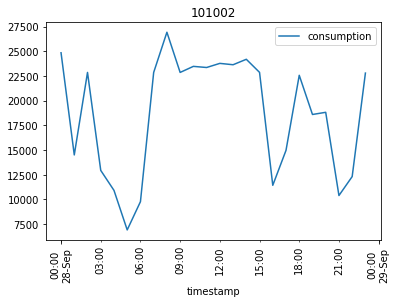

In [37]:
# plot samples
sample_ser = (my_submission[my_submission.prediction_window == 'hourly']
                           .series_id
                           .sample().values[0])

(my_submission[my_submission.series_id == sample_ser]
              .plot(x='timestamp',
                    y='consumption',
                    title=sample_ser,
                    rot=90))

In [38]:
my_submission.iloc[:,:-1].to_csv("submissions/my_submmission_20181001_2.csv", index_label='pred_id')

-------

In [50]:
def RMSE(y, pred):
    return mean_squared_error(y, pred)**0.5

def MAE(y, pred):
    return sum([abs(i) for i in (y-pred)])/y.shape[0]

In [58]:
def create_train_test(train_size, test_size, data, limit=5800):
    train = data[:train_size]
    test  = data[train_size:limit]
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    return scaler, train, test

In [59]:
def split_train_test(train, test):
    # Split into input and outputs 
    train_X, train_y = train[:,:-5], train[:,-5:]
    test_X, test_y = test[:, :-5], test[:, -5:]
    # LSTM requires 3D data sets: [samples, timesteps, features]
    total_features = train_X.shape[1]
    train_X = train_X.reshape(train_X.shape[0],7,int(total_features/7))
    test_X = test_X.reshape(test_X.shape[0], 7,int(total_features/7))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    return train_X, train_y, test_X, test_y

In [60]:
def fit_lstm(train_X, train_y, layers=3, n_batch=50, n_neurons=100, n_epochs=100, n_output=1, dropout=0):
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, train_X.shape[1], train_X.shape[2]),
                 stateful=True, activation='tanh', return_sequences=True))
    for i in range(layers-2):
        model.add(LSTM(n_neurons, stateful=True, activation='tanh', return_sequences=True, dropout=dropout))
    model.add(LSTM(n_neurons, stateful=True, activation='relu', dropout=dropout))
    model.add(Dense(n_output))
    model.compile(loss='mse', optimizer='adam')
    for i in range(int(train_X.shape[0] / n_batch)):
        this_X = train_X[(i * n_batch):((i + 1) * n_batch)][:][:]
        this_y = train_y[(i * n_batch):((i + 1) * n_batch)]
        history = model.fit(this_X, this_y, epochs=n_epochs, 
                                    batch_size=n_batch, 
                                    verbose=1, shuffle=False)
        model.reset_states()
    return model, history, n_batch

In [61]:
def evaluate_model(model, test_X, test_y, scaler, n_batch, n_samples=1):

    y_pred = [test_X.shape[0]]
    for i in range(int(test_X.shape[0] / n_batch)):
        this_X = test_X[(i * n_batch):((i + 1) * n_batch)][:][:]
        this_pred = model.predict(this_X, batch_size=n_batch)    
        y_pred[(i * n_batch):((i + 1) * n_batch)] = [list(i) for i in this_pred]
    
    test_X_nn = test_X.reshape((test_X.shape[0], test_X.shape[1]*test_X.shape[2]))
    # Invert scaling for forecast
    inv_y_pred = np.concatenate((y_pred, test_X_nn[:, :]), axis=1)
    inv_y_pred = scaler.inverse_transform(inv_y_pred)
    inv_y_pred = inv_y_pred[:,:5]
    inv_y_pred = np.round(np.maximum(inv_y_pred, 0))
    # Invert scaling for actual
    test_y_nn = test_y.reshape((len(test_y), 5))
    inv_y = np.concatenate((test_y_nn, test_X_nn[:, :]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,:5]
    # print scores
    print(inv_y_pred[:10])
    print(inv_y[:10])
    rmse = dict()
    for i in range(n_samples):
        rmse[i] = RMSE([m[i]/4 for m in inv_y], [n[i]/4 for n in inv_y_pred])
        print('Test RMSE: %.3f' % rmse[i])
    
    return rmse, inv_y_pred, inv_y

In [62]:
def append_prediction(df, prediction):
    pred_df = df.iloc[-prediction.shape[0]-26:-26,:]
#     pred_df = df.iloc[-prediction.shape[0]-33:-33,:]
    for i in range(prediction.shape[1]):
        pred_df['prediction{}'.format(i)] = [x[i] for x in prediction]
    return pred_df

In [63]:
def append_baseline(data, n_samples):
    baseline = dict()
    for i in range(n_samples):
        baseline[i] = data.iloc[:5100,:].groupby(['hour'])['swaps{}'.format(i)].quantile(.75)
        baseline[i] = baseline[i].reset_index()
        baseline[i].rename(columns={'swaps{}'.format(i):'baseline{}'.format(i)}, inplace=True)
        data = data.merge(baseline[i], on='hour', how='left')
    return data

In [64]:
def plot_forecast_multi(data, range_lower=-700, range_upper=None, n_samples=1):
    plt.subplots(n_samples, 1, figsize=(20,6*n_samples))
    for i in range(n_samples):
        plt.subplot(n_samples, 1, i+1)
        plt.plot(data.iloc[range_lower:range_upper].index, np.round(data.iloc[range_lower:range_upper,i]/4), label='Real')
        plt.plot(data.iloc[range_lower:range_upper].index, np.round(data.iloc[range_lower:range_upper,list(data.columns).index('prediction{}'.format(i))]/4), label='Predict')
        plt.plot(data.iloc[range_lower:range_upper].index, np.round(data.iloc[range_lower:range_upper,list(data.columns).index('baseline{}'.format(i))]/4), label='Baseline')
        plt.xlabel('Date Time', fontsize=16)
        plt.ylabel('Swaps', fontsize=16)
        plt.legend();

In [65]:
def run_experiment(vmlist, layers, n_batch, n_neurons, n_epochs, dropout):
    #select GoStations to forecast
    df_station = df[df.vmid.isin(vmlist)]
    df_station = pd.pivot_table(df_station, values='swaps', index='datetime', columns='vmid')
    df_station['hour'] = df_station.index.hour
    
    #rename columns
    cols = df_station.columns
    for n, i in enumerate(cols[:-1]):
        df_station.rename(columns={i:'swaps'+str(n)}, inplace=True)
        
    prep_df = pd.concat([df_station[list(df_station.columns)[:-1]], pd.get_dummies(df_station['hour'], prefix='hour')], axis=1)
    prep_df.loc[prep_df.index.dayofweek>4, 'weekend'] = 1
    prep_df['weekend'].fillna(0, inplace=True)
    cols = prep_df.columns
    tmp = pd.DataFrame(series_to_supervised(prep_df, 7, 1))
    tmp.drop(tmp.columns[-(prep_df.shape[1] - len(vmlist)):], axis=1, inplace=True)
    super_data = tmp
    
    #split train/test set and scale
    scaler, train, test = create_train_test(5100, len(super_data)-5100-26, super_data)
    train_X, train_y, test_X, test_y = split_train_test(train, test)
    
    #train model
    model, history, n_batch = fit_lstm(train_X, train_y, layers, n_batch, n_neurons, n_epochs, len(vmlist), dropout)
    rmse, inv_y_pred, inv_y = evaluate_model(model, test_X, test_y, scaler, n_batch, len(vmlist))
    
    #create dataframe with all predictions and real data
    pred_prep_df = append_prediction(prep_df, inv_y_pred)
    pred_prep_df['hour']=pred_prep_df.index.hour
    pred_index = pred_prep_df.index
    pred_prep_df = append_baseline(pred_prep_df, len(vmlist))
    pred_prep_df.index = pred_index
    
    hyperparam = pd.DataFrame(data={'layers':[layers],'batch_size':[n_batch],'neurons':[n_neurons],'epochs':[n_epochs],'dropout':[dropout],
                   'RMSE0':[rmse[0]],'RMSE1':[rmse[1]],'RMSE2':[rmse[2]],'RMSE3':[rmse[3]],'RMSE4':[rmse[4]]})
    
    return pred_prep_df, hyperparam

In [66]:
def append_results(df, vmlist, layers, n_batch, n_neurons, n_epochs, dropout):
    pred_prep_df, hyperparam = run_experiment(vmlist, layers, n_batch, n_neurons, n_epochs, dropout)
    df = df.append(hyperparam)
    return df, pred_prep_df

--------

In [192]:
# lag of 24 to simulate smallest cold start window. Our series
# will be converted to a num_timesteps x lag size matrix
lag =  24

# model parameters
num_neurons = 24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)

# instantiate a sequential model
model = Sequential()

# add LSTM layer - stateful MUST be true here in 
# order to learn the patterns within a series
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, 
              stateful=True))

# followed by a dense layer with a single output for regression
model.add(Dense(1))

# compile
model.compile(loss='mean_absolute_error', optimizer='adam')

In [129]:
%%time
num_training_series = consumption_train.series_id.nunique()
num_passes_through_data = 3

for i in tqdm(range(num_passes_through_data), 
              total=num_passes_through_data, 
              desc='Learning Consumption Trends - Epoch'):
    
    # reset the LSTM state for training on each series
    for ser_id, ser_data in consumption_train.groupby('series_id'):

        # prepare the data
        X, y, scaler = prepare_training_data(ser_data.consumption, lag)

        # fit the model: note that we don't shuffle batches (it would ruin the sequence)
        # and that we reset states only after an entire X has been fit, instead of after
        # each (size 1) batch, as is the case when stateful=False
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()

Learning Consumption Trends - Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/1
648/648 [==============================] - 2s 2ms/step - loss: 0.1114
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1520
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1415
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1346
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1105
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1320
Epoch 1/1
648/648 [==============================] - 2s 2ms/step - loss: 0.1142
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1187
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1007
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1112


Learning Consumption Trends - Epoch:  33%|███▎      | 1/3 [00:14<00:28, 14.12s/it]

Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.0959
Epoch 1/1
648/648 [==============================] - 2s 3ms/step - loss: 0.1438
Epoch 1/1
648/648 [==============================] - 2s 2ms/step - loss: 0.1425
Epoch 1/1
648/648 [==============================] - 2s 3ms/step - loss: 0.1332
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1060
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1288
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1093
Epoch 1/1
648/648 [==============================] - 2s 2ms/step - loss: 0.1164
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.0994
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1090


Learning Consumption Trends - Epoch:  67%|██████▋   | 2/3 [00:29<00:14, 14.72s/it]

Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.0968
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1421
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1420
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1324
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1050
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1263
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1099
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1160
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1006
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1091


Learning Consumption Trends - Epoch: 100%|██████████| 3/3 [00:42<00:00, 14.11s/it]

CPU times: user 1min 1s, sys: 12 s, total: 1min 13s
Wall time: 42.4 s


In [115]:
%%time
pred_window_to_num_preds = {'hourly': 24, 'daily': 7, 'weekly': 2}
pred_window_to_num_pred_hours = {'hourly': 24, 'daily': 7 * 24, 'weekly': 2 * 7 * 24}

num_test_series = my_submission.series_id.nunique()

model.reset_states()

for ser_id, pred_df in tqdm(my_submission.groupby('series_id'), 
                            total=num_test_series, 
                            desc="Forecasting from Cold Start Data"):
        
    # get info about this series' prediction window
    pred_window = pred_df.prediction_window.unique()[0]
    num_preds = pred_window_to_num_preds[pred_window]
    num_pred_hours = pred_window_to_num_pred_hours[pred_window]
    
    # prepare cold start data
    series_data = consumption_test[consumption_test.series_id == ser_id].consumption
    cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
    
    # fine tune our lstm model to this site using cold start data    
    model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    
    # make hourly forecasts for duration of pred window
    preds = generate_hourly_forecast(num_pred_hours, series_data, model, scaler, lag)
    
    # reduce by taking sum over each sub window in pred window
    reduced_preds = [pred.sum() for pred in np.split(preds, num_preds)]
    
    # store result in submission DataFrame
    ser_id_mask = my_submission.series_id == ser_id
    my_submission.loc[ser_id_mask, 'consumption'] = reduced_preds

Forecasting from Cold Start Data: 100%|██████████| 625/625 [05:53<00:00,  1.77it/s]

CPU times: user 7min 17s, sys: 1min 2s, total: 8min 19s
Wall time: 5min 53s
